# Multi-class classification based on Softmax and Cross-Entropy using pytorch

## import libraries

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

## load data

In [20]:
#directory_data  = '/assignment_06_data.npz'
filename_data   = 'assignment_06_data.npz'
data            = np.load(os.path.join(filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

*************************************************
size of x_train : (20000, 32, 32)
size of y_train : (20000,)
*************************************************
size of x_test : (8000, 32, 32)
size of y_test : (8000,)
*************************************************
number of training image : 20000
height of training image : 32
width of training image : 32
*************************************************
number of testing image : 8000
height of testing image : 32
width of testing image : 32
*************************************************


## number of classes

In [4]:
print('*************************************************')
print('number of classes :', len(set(y_train)))
print('*************************************************')

*************************************************
number of classes : 10
*************************************************


## hyper-parameters

In [5]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 100
size_minibatch  = 32
learning_rate   = 0.01
weight_decay    = 1e-2

## custom data loader for the PyTorch framework

In [6]:
class dataset(Dataset):
    
    def __init__(self, image, label):
        
        self.image  = image
        self.label  = label.astype(np.long)
    
    def __getitem__(self, index):
        
        image   = self.image[index, :, :]
        label   = self.label[index, ]

        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        label   = torch.LongTensor([label])

        return image, label
    
    def __len__(self):
        
        return self.image.shape[0]

    def collate_fn(self, batch):
        images  = list()
        labels  = list()

        for b in batch:
            images.append(b[0])
            labels.append(b[1])

        images  = torch.stack(images, dim=0)
        labels  = torch.stack(labels, dim=0).squeeze()

        return images, labels
        

## construct datasets and dataloaders for training and testing

In [7]:
dataset_train   = dataset(x_train, y_train)
dataset_test    = dataset(x_test, y_test)

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_train.collate_fn)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_test.collate_fn)

## shape of the data when using the data loader

In [8]:
image, label    = next(iter(dataloader_train))
print('************************************************************')
print('size of mini-batch of the image:', image.shape)
print('************************************************************')
print('size of mini-batch of the label:', label.shape)
print('************************************************************')

************************************************************
size of mini-batch of the image: torch.Size([32, 1, 32, 32])
************************************************************
size of mini-batch of the label: torch.Size([32])
************************************************************


## class for the neural network 

In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.feature    = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128, 64, bias=True),
            nn.ReLU(),
            nn.Linear(64, 10, bias=True),
        )

        self.network    = nn.Sequential(
            self.feature,
            nn.Flatten(),
            self.classifier,
        )

        self.initialize()


    def initialize(self):

        for m in self.network.modules():

            if isinstance(m, nn.Conv2d):

                nn.init.constant_(m.weight, 0.01)
                nn.init.constant_(m.bias, 1)

            elif isinstance(m, nn.Linear):

                nn.init.constant_(m.weight, 0.01)
                nn.init.constant_(m.bias, 1)


    def forward(self, input):

        output = self.network(input)

        return output

    

## build network

In [10]:
classifier  = Classifier().to(device)
optimizer   = torch.optim.SGD(classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

## print the defined neural network

In [11]:
print(classifier)

Classifier(
  (feature): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
  (network): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
      (3): Conv2d(2, 4, kernel_size=(3, 3), st

## compute the prediction

In [12]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the loss

In [13]:
def compute_loss(prediction, label):

    criterion   = nn.CrossEntropyLoss()
    loss        = criterion(prediction, label)
    loss_value  = loss.item()

    return loss, loss_value

## compute the accuracy

In [14]:
def compute_accuracy(prediction, label):
    s = 0
    
    for i in range(label.shape[0]):
        
        if(prediction[i].argmax() == label[i]):
            s+=1
            
    accuracy = s /label.shape[0]

    return accuracy

## variables for the learning curve

In [15]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train and test

In [16]:
for i in tqdm(range(number_epoch)):
    loss_train_epoch        = []
    accuracy_train_epoch    = []

    classifier.train()

    for index_batch, (image_train, label_train) in enumerate(dataloader_train):

        image_train = image_train.to(device)
        label_train = label_train.to(device)
        
        prediction_train                = compute_prediction(classifier, image_train)
        loss_train, loss_value_train    = compute_loss(prediction_train, label_train)
        accuracy_train                  = compute_accuracy(prediction_train, label_train)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        loss_train_epoch.append(loss_value_train)
        accuracy_train_epoch.append(accuracy_train)

    loss_mean_train[i]      = np.mean(loss_train_epoch)
    loss_std_train[i]       = np.std(loss_train_epoch)

    accuracy_mean_train[i]  = np.mean(accuracy_train_epoch)
    accuracy_std_train[i]   = np.std(accuracy_train_epoch)

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    loss_test_epoch        = []
    accuracy_test_epoch    = []

    classifier.eval()

    for index_batch, (image_test, label_test) in enumerate(dataloader_test):

        image_test = image_test.to(device)
        label_test = label_test.to(device)
        
        prediction_test             = compute_prediction(classifier, image_test)
        loss_test, loss_value_test  = compute_loss(prediction_test, label_test)
        accuracy_test               = compute_accuracy(prediction_test, label_test)

        loss_test_epoch.append(loss_value_test)
        accuracy_test_epoch.append(accuracy_test)

    loss_mean_test[i]      = np.mean(loss_test_epoch)
    loss_std_test[i]       = np.std(loss_test_epoch)

    accuracy_mean_test[i]  = np.mean(accuracy_test)
    accuracy_std_test[i]   = np.std(accuracy_test)

  1%|▊                                                                                 | 1/100 [00:08<14:13,  8.62s/it]


KeyboardInterrupt: 

## plot curve

In [205]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [206]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [207]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [208]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [209]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [210]:
def function_result_01():

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [211]:
def function_result_02():

    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [212]:
def function_result_03():
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [213]:
def function_result_04():
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [214]:
def function_result_05():
    
    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [215]:
def function_result_06():
    
    data_last = get_data_last(accuracy_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [216]:
def function_result_07():
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [217]:
def function_result_08():
    
    data_last = get_data_last(accuracy_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [218]:
def function_result_09():
    
    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [219]:
def function_result_10():
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---

## # 01. plot the training loss curve (mean, std)

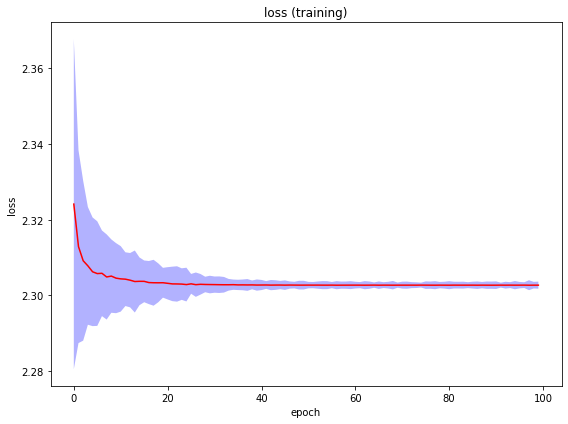

In [220]:
function_result_01()

## # 02. plot the training accuracy curve (mean, std)

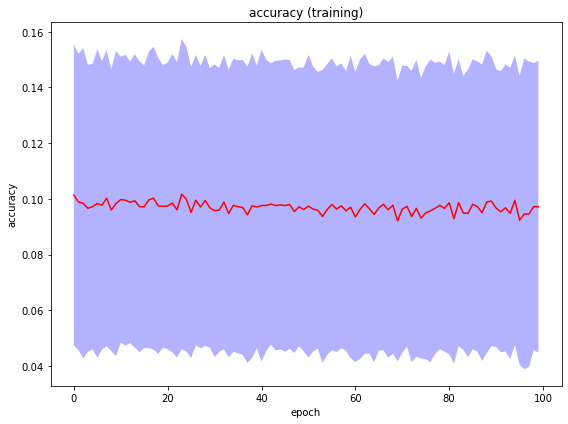

In [221]:
function_result_02()

## # 03. plot the testing loss curve (mean, std)

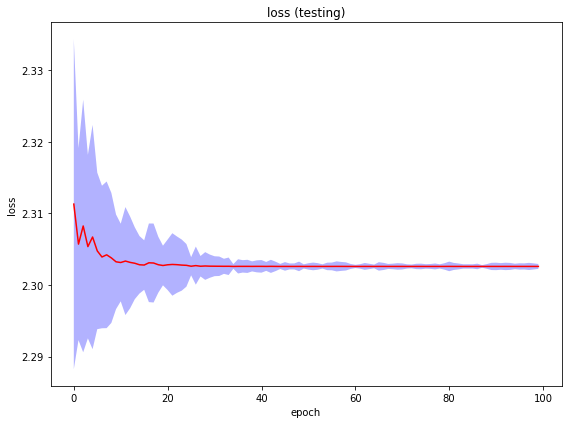

In [222]:
function_result_03()

## # 04. plot the testing accuracy curve (mean, std)

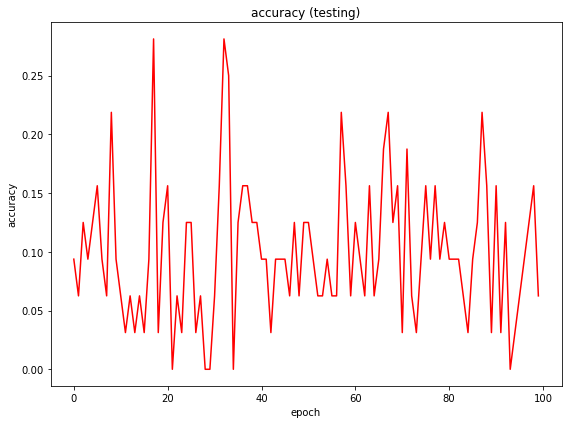

In [223]:
function_result_04()

## # 05. print the training (mean) loss over batches at last 10 epochs

In [224]:
function_result_05()

index =  0, value = 2.3027053528
index =  1, value = 2.3027175358
index =  2, value = 2.3027064415
index =  3, value = 2.3027183041
index =  4, value = 2.3027083885
index =  5, value = 2.3027114208
index =  6, value = 2.3027191143
index =  7, value = 2.3026963581
index =  8, value = 2.3027090050
index =  9, value = 2.3027108410


## # 06. print the training (mean) accuracy over batches at last 10 epochs

In [225]:
function_result_06()

index =  0, value = 0.0967000000
index =  1, value = 0.0954000000
index =  2, value = 0.0968000000
index =  3, value = 0.0948000000
index =  4, value = 0.0995000000
index =  5, value = 0.0923500000
index =  6, value = 0.0946000000
index =  7, value = 0.0945500000
index =  8, value = 0.0972500000
index =  9, value = 0.0972000000


## # 07. print the testing (mean) loss over batches at last 10 epochs

In [226]:
function_result_07()

index =  0, value = 2.3025890608
index =  1, value = 2.3025884113
index =  2, value = 2.3025901279
index =  3, value = 2.3025890636
index =  4, value = 2.3025875034
index =  5, value = 2.3025885983
index =  6, value = 2.3025879631
index =  7, value = 2.3025887489
index =  8, value = 2.3025883293
index =  9, value = 2.3025870380


## # 08. print the testing (mean) accuracy over batches at last 10 epochs

In [227]:
function_result_08()

index =  0, value = 0.1562500000
index =  1, value = 0.0312500000
index =  2, value = 0.1250000000
index =  3, value = 0.0000000000
index =  4, value = 0.0312500000
index =  5, value = 0.0625000000
index =  6, value = 0.0937500000
index =  7, value = 0.1250000000
index =  8, value = 0.1562500000
index =  9, value = 0.0625000000


## # 09. print the best training (mean) accuracy within the last 10 epochs

In [228]:
function_result_09()

best training accuracy = 0.0995000000


## # 10. print the best testing (mean) accuracy within the last 10 epochs

In [229]:
function_result_10()

best testing accuracy = 0.1562500000
